# Regularized regression

Here we solve two simple $\ell_1$-penalized regression problems using `cvxpy`. For that, we will try to infer the parameters of a

- a normally distributed response,
- and a binomially distirbuted response.

We start with loading some libraries.

In [1]:
from cvxpy import *
import numpy as np
import scipy as sp

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt

## Linear regression

First we solve a classic linear regression problem were the response is modelled:

\begin{align*}
y \sim \mathcal{N}(X \beta, \sigma^2 I_n),
\end{align*}

where $y \in \mathbb{R}^n$, $X \in \mathbb{R}^{n \times p}$ and $\beta \in \mathbb{R}^p$.
The usual way of finding the *optimal* esimates $\hat{\beta}$ is by maximum likelihood, i.e. by maximizing the log-likelihood function:

\begin{align*}
\max_{\beta} \sum_i^n \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(- \frac{ \left(y_i - x_i^T \beta \right)^2}{2\sigma^2}\right)   \right),
\end{align*}

which means that we are estimating $\mathbb{E}(Y \mid X)$. In the loss function above we see that we only need to optimze the numerator in the exponent, so we can drop the rest. In addition we multiply the likelihood function with $-1$, such that we instead of maximizing minimize the function. There is no difference between the two, but most of the optimization literature formulate their problems as minimization tasks:

\begin{align*}
\min_{\beta} & - \sum_i^n \log \exp \left(-  \left(y_i - x_i^T \beta \right)^2 \right) \\
& = \sum_i^n \left(y_i - x_i^T \beta \right)^2
\end{align*}


Furthermore, we want to add $\ell_1$-penalization for the coefficients. So the loss function becomes:

\begin{align*}
\min_{\beta} & \sum_i^n \left(y_i - x_i^T \beta \right)^2 + \lambda ||\beta||_1\\
& = ||Y - X\beta||_2^2 + \lambda ||\beta||_1
\end{align*}


Let's try this using the Boston housing data.

In [2]:
x, y = datasets.load_boston(True)
x = np.c_[np.ones((x.shape[0], 1)), x]
y = (y - np.mean(y)) / np.std(y)

Plot a histogram of the response:

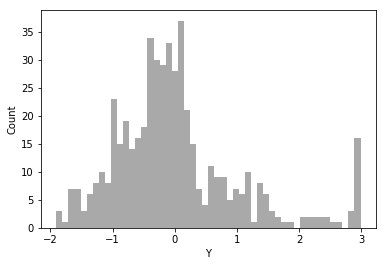

In [3]:
plt.hist(y, bins=50, color="darkgrey")
plt.xlabel('Y')
plt.ylabel('Count')
plt.show()

The data does not look Gaussian, but since we only want to try a numerical solver, this is not a big deal.

The next section sets up our problem as a convex optimization task. Since the loss function defined a above is a quadratic function of a single variable ($\beta$), its curvature is convex, and we can use a numerical solver for convex functions from `cvxpy`.

First, we define the variables to optimize over and a constraint for $\lambda$. We set it to one here, actually you should optimize this, e.g. using cross-validation.

In [4]:
beta = Variable(x.shape[1])
lamb = Parameter(sign="positive")
lamb.value = 0

Then we define and solve the loss function as a convex problem.

In [5]:
loss = norm(y - x * beta, 2) 
prob = Problem(Minimize(loss))
prob.solve()

11.456547564420289

Get the estimates for beta $\hat{\beta}$.

In [6]:
beta_hat = np.asarray(beta.value).flatten()

Compute the means for the responses $\hat{y}$.

In [7]:
y_hat = np.dot(x, beta_hat)

Compute the residual sum of squares and coefficient of determination $R^2$ to estimate the model quality:

In [8]:
residual_sum_of_squares = mean_squared_error(y, y_hat)
r_squared = r2_score(y, y_hat)
print("RSS: ", residual_sum_of_squares)
print("R^2: ", r_squared)

RSS:  0.25939225713594094
R^2:  0.740607742864059


Finally we compute a Tukey-Ascombe plot of our data using the residuals against $\hat{y}$.

In [9]:
residuals = y - y_hat

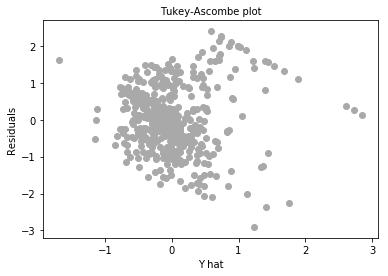

In [10]:
plt.scatter(residuals, y_hat, color="darkgrey")
plt.title('Tukey-Ascombe plot', fontsize=10)
plt.xlabel(r'Y hat')
plt.ylabel('Residuals')
plt.show()

Plot a histogram of the residuals.

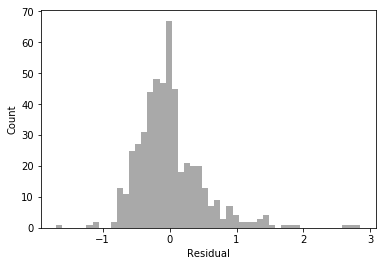

In [11]:
plt.hist(residuals, bins=50, color="darkgrey")
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

As for the responses $y$, the residuals don't really look normal.

## Logistic regression

Next we solve a logistic regression problem were the response (in our setting) is modelled as:

\begin{align*}
y \sim \mathcal{Bernoulli}\left(\text{logit}^{-1} \left( x \beta \right) \right),
\end{align*}

where $x \in \mathbb{R}^{p}$ and $\beta \in \mathbb{R}^p$.

Here we use a *logit* link function $g$, in order to ensure that $x \beta$ is a probability. The invsere of the logit link, gives us the mean function $h$:

\begin{align*}
g^{-1}(x_i\beta) = h(x_i\beta) = \text{logit}^{-1}(x_i\beta) = \frac{1}{1 + \exp(-x_i\beta)}.
\end{align*}

For brevity we will denote 

\begin{align*}
\phi_i = h(x_i \beta)
\end{align*}

As before the usual way of finding the *optimal* esimates $\hat{\beta}$ is by maximum likelihood, i.e. by maximizing the log-likelihood function:

\begin{align*}
\max_{\beta} & \; \log \prod_i^n  \left[\phi_i^{y_i} \cdot \left(1 -\phi_i\right) ^{\left(1 - y_i\right)}  \right],\\
& \; = \sum_i^n y_i \log(\phi_i) + (1-y_i)\log(1-\phi_i)
\end{align*}

which means that we are estimating $\mathbb{E}(Y \mid X)$ again. As before we multiply the likelihood function with $-1$ and add an $\ell_1$ penalty:

\begin{align*}
\min_{\beta} & - \sum_i^n y_i \log(\phi_i) + (1-y_i)\log(1-\phi_i) + \lambda ||\beta||_1
\end{align*}

In order to make this work with `cvxpy` we cannot directly implement $\log(\phi_i)$, because it would violate the DCP rules. So even though this formulation is convex, the solver would reject it. However, `cvxpy` implements the `logistic` function as $\text{logistic}(x) = \log(1  + \exp(x))$.
So, we re-write our objective using:

\begin{align*}
\log(\phi_i) &= \log\left( \frac{1}{1 + \exp(-x_i \beta)}  \right) = - \log(1 + \exp(-x_i \beta)) = - \text{logistic}(-x_i \beta),\\
\log(1- \phi_i) &= \log\left( 1- \frac{1}{1 + \exp(-x_i \beta)}  \right) = \log \left( \frac{\exp(-x_i \beta)}{1 + \exp(-x_i \beta)}  \right) \\
&= -x_i \beta - \log(1 + \exp(-x_i \beta)) = -x_i \beta - \text{logistic}(-x_i \beta)
\end{align*}

So the regularized negative log-likelihood becomes:

\begin{align*}
\min_{\beta} &  \sum_i^n  y_i \cdot \text{logistic}(-x_i \beta) + (1 - y_i) \cdot  (x_i \beta + \text{logistic}(-x_i \beta)) + \lambda ||\beta||_1\\
& =  \sum_i^n x_i \beta + \text{logistic}(-x_i \beta) - y_i x_i \beta + \lambda ||\beta||_1\\
& =  x_{\{i \mid y_i = 0 \}} \beta + \text{logistic}(-x_i \beta) + \lambda ||\beta||_1
\end{align*} 

(Note that the sign changed here because we dropped the minus).

Before the optimization of the negative log-likelihood was identical to solving an ordinary least squares problem. Here we have to optimize the likelihood, though. That's no tragedy though and can be done efficiently.

Let's begin by loading some data:

In [12]:
x, y = datasets.load_breast_cancer(True)
x = np.c_[np.ones((x.shape[0], 1)), x]

It's important to check here if our data are balanced, and that the labels are $y_i \in \{0, 1\}$ (since we are using a Bernoulli likelihood).

In [13]:
print("Labels: ", np.unique(y))
print("Count y == 0: ", len(y[y==0]))
print("Count y == 1: ", len(y[y==1]))

Labels:  [0 1]
Count y == 0:  212
Count y == 1:  357


Since the labels are not balanced we randomly select 100 observations from each group.

In [14]:
np.random.seed(23)

y0_idx = np.where(y==0)[0]
np.random.shuffle(y0_idx)
y1_idx = np.where(y!=0)[0]
np.random.shuffle(y1_idx)

idx = np.append(y0_idx[:100], y1_idx[:100])
np.random.shuffle(idx)

x, y = x[idx, :], y[idx]

Let's visualize this in two dimensions

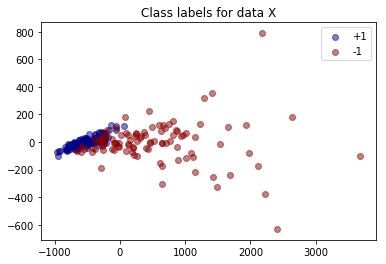

In [15]:
pc = PCA(n_components=2).fit_transform(x)

_, ax = plt.subplots()
ax.scatter(pc[y == 1, 0], pc[y == 1, 1], c="darkblue", label="+1", alpha=0.5)
ax.scatter(pc[y != 1, 0], pc[y != 1, 1], c="darkred", label="-1", alpha=0.5)
ax.legend()
ax.set_title("Class labels for data X")
plt.show()

Next we formalize our problem using `cvxpy`. As before, we want to optimize over $\beta$ and put an $\ell_1$ penalty on it:

In [16]:
beta = Variable(x.shape[1])
lamb = Parameter(sign="positive")
lamb.value = 0.1

The loss function is a little bit more complicated this time:

In [17]:
loss = sum(x[y == 0,:] * beta) + sum(logistic(-x * beta)) + lamb * norm(beta, 1)
prob = Problem(Minimize(loss))
prob.solve()

19.276483928904206

In [22]:
prob.solver_stats.solver_name

'ECOS'

In [18]:
beta_hat = np.asarray(beta.value).flatten()

Here we compute the means of the responses and then convert them to binary labels using a threshold of $.5$.

In [19]:
y_hat = 1/(1 + np.exp(-x.dot(beta_hat)))
y_hat[ y_hat >= .5] = 1
y_hat[ y_hat < .5] = 0
y_hat = np.ndarray.astype(y_hat, "int")

Next we plot our estimated labels in a principal component space:

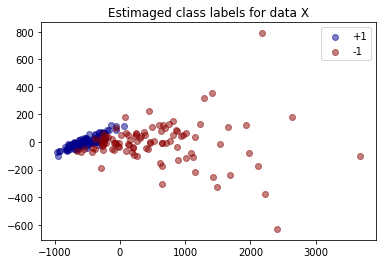

In [20]:
pc = PCA(n_components=2).fit_transform(x)

_, ax = plt.subplots()
ax.scatter(pc[y_hat == 1, 0], pc[y_hat == 1, 1], c="darkblue", label="+1", alpha=0.5)
ax.scatter(pc[y_hat != 1, 0], pc[y_hat != 1, 1], c="darkred", label="-1", alpha=0.5)
ax.legend()
ax.set_title("Estimaged class labels for data X")
plt.show()

Finally we plot a confusion matrix to see numbers of false positive and false negative, i.e. miss-classifications:

In [21]:
def plot_confusion_matrix(cm, classes):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

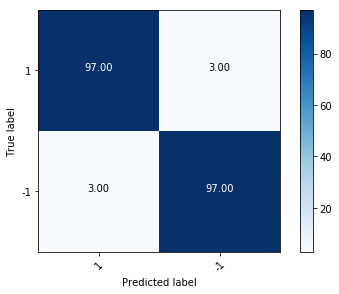

In [22]:
plot_confusion_matrix(confusion_matrix(y, y_hat), classes=["1", "-1"])

We were able to almost perfectly separate the data? That seems unlikely ...